In [1]:
import errno
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.models import load_model
from sklearn.metrics import jaccard_similarity_score
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict

from datetime import datetime

from keras import __version__
print(__version__)

Using TensorFlow backend.


2.0.5


In [49]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

K.set_image_data_format('channels_first')

N_Cls = 1
data_base_dir = "/home/ubuntu/data/"
inDir = './'
mkdir_p(inDir + '/data')
out_dir = 'output/'
mkdir_p(out_dir)

print(os.getcwd())
DF = pd.read_csv(data_base_dir+'train_wkt_v4_TREES.csv')
val_DF = pd.read_csv(data_base_dir+'val_wkt_v4_TREES.csv')
GS = pd.read_csv(data_base_dir+'grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
SB = pd.read_csv(data_base_dir+'sample_submission.csv')

ISZ = 160
smooth = 1e-12

EPSILON = 2  # polygon edge smoothing factor (higher=less nodes, i.e. less detail)
MIN_AREA = 5.  # smallest area a polygon can be

val_img_names = ["6010_4_4", "6070_2_3", "6100_2_3", "6140_1_2", "6110_4_0"]

/home/ubuntu/git/kaggle-dstl/keras2-baseline-improvements


# Image preprocessing

In [3]:
def _convert_coordinates_to_raster(coords, img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int


def _get_xmax_ymin(grid_sizes_panda, imageId):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)


def _get_polygon_list(wkt_list_pandas, imageId, cType):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList


def _get_and_convert_contours(polygonList, raster_img_size, xymax):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = _convert_coordinates_to_raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = _convert_coordinates_to_raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list


def _plot_mask_from_contours(raster_img_size, contours, class_value=1):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask


def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GS, wkt_list_pandas=DF):
    # __author__ = visoft
    # https://www.kaggle.com/visoft/dstl-satellite-imagery-feature-detection/export-pixel-wise-mask
    xymax = _get_xmax_ymin(grid_sizes_panda, imageId)  # for scaling according to competition
    polygon_list = _get_polygon_list(wkt_list_pandas, imageId, class_type)  # read (training) polygon data
    contours = _get_and_convert_contours(polygon_list, raster_size, xymax)  # creating outline from vector nodes
    mask = _plot_mask_from_contours(raster_size, contours, 1)  # filling in polygon outlines (i.e. creating the mask)
    return mask


def M(image_id):
    # __author__ = amaia
    # https://www.kaggle.com/aamaia/dstl-satellite-imagery-feature-detection/rgb-using-m-bands-example
    filename = os.path.join(data_base_dir, 'sixteen_band', '{}_M.tif'.format(image_id))
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)
    return img


def stretch_n(bands, lower_percent=0, higher_percent=100): # <- "Claims to improve" (was lower_percent=5, higher_percent=95)
    # "Contrast enhancement", see https://www.kaggle.com/aamaia/rgb-using-m-bands-example
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)


def stick_all_train():
    print("let's stick all imgs together")
    s = 835  # size of the M images

    # 25 training images grid
    x = np.zeros((5 * s, 4 * s, 8))
    y = np.zeros((5 * s, 4 * s, N_Cls))   # axis=2 denote the class label

    ids = sorted(DF.ImageId.unique())
    print(len(ids))

    # x start grid position (based on image size)
    for i in range(5):
        # y start grid position (based on image size)
        for j in range(4):
            id = ids[1 * i + j]

            img = M(id)
            img = stretch_n(img)
            print(img.shape, id, np.amax(img), np.amin(img))
            x[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
            # generate training masks by class
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]

    print(np.amax(y), np.amin(y))
    
    np.save(inDir + '/data/x_trn_%d' % N_Cls, x)
    np.save(inDir + '/data/y_trn_%d' % N_Cls, y)

    
def get_patches(img, msk, amt=10000, aug=True):
    is2 = int(1.0 * ISZ)  # ISZ=is2=patch size
    xm, ym = img.shape[0] - is2, img.shape[1] - is2  # starting coordinate for getting patches (taking into consideration padding)

    x, y = [], []

    # threshold determining when to add an image - if the image contains a greater percentage of pixels in the training
    # set than specified by the thresholds below:
    tr = [0.3]
    
    count = 0

    for i in range(amt):
        do_we_append = False
        
        # get random point in inner image (i.e exluding the outer image padding)
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        # get patch
        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

        for j in range(N_Cls):
            # sum pixels containing class j
            sm = np.sum(ms[:, :, j])
            if aug:
                if random.uniform(0, 1) > 0.5:
                    im = im[::-1]
                    ms = ms[::-1]
                if random.uniform(0, 1) > 0.5:
                    im = im[:, ::-1]
                    ms = ms[:, ::-1]

            # calculate the percent of covered pixels (for one class) - check if greater than threshold.
            if 1.0 * sm / is2 ** 2 > tr[j]:
                do_we_append = True
            
            # Add "blank ones" with probability 0.1
            elif sm < 500:
                do_we_append = True
                count += 1
                print("Add blank, idx={}, count={}".format(i, count))
            
        if do_we_append:
            x.append(im)
            y.append(ms)

    x, y = 2 * np.transpose(x, (0, 3, 1, 2)) - 1, np.transpose(y, (0, 3, 1, 2))  # Maybe some sort of standardisation/normalisation
    print(x.shape, y.shape, np.amax(x), np.amin(x), np.amax(y), np.amin(y))
    return x, y

In [5]:
stick_all_train()  # sticking all training images in 5x5x10 grid (i.e. 5*M_pixels x 5*M_pixels x 10 classes)

let's stick all imgs together
20
(837, 849, 8) 6010_1_2 1.0 0.0
(837, 849, 8) 6010_4_2 1.0 0.0
(837, 848, 8) 6040_1_0 1.0 0.0
(837, 848, 8) 6040_1_3 1.0 0.0
(837, 849, 8) 6010_4_2 1.0 0.0
(837, 848, 8) 6040_1_0 1.0 0.0
(837, 848, 8) 6040_1_3 1.0 0.0
(837, 848, 8) 6040_2_2 1.0 0.0
(837, 848, 8) 6040_1_0 1.0 0.0
(837, 848, 8) 6040_1_3 1.0 0.0
(837, 848, 8) 6040_2_2 1.0 0.0
(837, 846, 8) 6040_4_4 1.0 0.0
(837, 848, 8) 6040_1_3 1.0 0.0
(837, 848, 8) 6040_2_2 1.0 0.0
(837, 846, 8) 6040_4_4 1.0 0.0
(837, 851, 8) 6060_2_3 1.0 0.0
(837, 848, 8) 6040_2_2 1.0 0.0
(837, 846, 8) 6040_4_4 1.0 0.0
(837, 851, 8) 6060_2_3 1.0 0.0
(837, 848, 8) 6090_2_0 1.0 0.0
1.0 0.0


## Create custom validation set

In [4]:
def make_val(aug=False):
    print("let's pick some samples for validation")
    img = np.load(inDir + '/data/x_valALL_%d.npy' % N_Cls)
    msk = np.load(inDir + '/data/y_valALL_%d.npy' % N_Cls)
    x, y = get_patches(img, msk, amt=3000, aug=aug)  # amt := attempt (maybe - i.e. attempting to create 3000 patches, without
                                            # percentage area cover threshold.

    print("Validation data shapes:")
    print(x.shape)
    print(y.shape)

    np.save(inDir + '/data/x_val_%d' % N_Cls, x)
    np.save(inDir + '/data/y_val_%d' % N_Cls, y)
    
    
def stick_all_val():
    print("let's stick all imgs together")
    s = 835  # size of the M images

    # 25 training images grid
    x = np.zeros((5 * s, 1 * s, 8))
    y = np.zeros((5 * s, 1 * s, N_Cls))   # axis=2 denote the class label

    ids = sorted(val_DF.ImageId.unique())
    print(len(ids))

    # x start grid position (based on image size)
    for i in range(5):
        # y start grid position (based on image size)
        for j in range(1):
            id = ids[1 * i + j]

            img = M(id)
            img = stretch_n(img)
            print(img.shape, id, np.amax(img), np.amin(img))
            x[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
            # generate training masks by class
            for z in range(N_Cls):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                    (img.shape[0], img.shape[1]), id, z + 1, wkt_list_pandas=val_DF)[:s, :s]

    print(np.amax(y), np.amin(y))

    np.save(inDir + '/data/x_valALL_%d' % N_Cls, x)
    np.save(inDir + '/data/y_valALL_%d' % N_Cls, y)

In [36]:
stick_all_val()
make_val()

let's stick all imgs together
5
(837, 848, 8) 6010_4_4 1.0 0.0
(838, 835, 8) 6070_2_3 1.0 0.0
(837, 848, 8) 6100_2_3 1.0 0.0
(837, 849, 8) 6110_4_0 1.0 0.0
(837, 849, 8) 6140_1_2 1.0 0.0
1.0 0.0
let's pick some samples for validation
Add blank, idx=14, count=1
Add blank, idx=28, count=2
Add blank, idx=39, count=3
Add blank, idx=44, count=4
Add blank, idx=71, count=5
Add blank, idx=86, count=6
Add blank, idx=97, count=7
Add blank, idx=104, count=8
Add blank, idx=110, count=9
Add blank, idx=135, count=10
Add blank, idx=136, count=11
Add blank, idx=139, count=12
Add blank, idx=140, count=13
Add blank, idx=145, count=14
Add blank, idx=159, count=15
Add blank, idx=173, count=16
Add blank, idx=179, count=17
Add blank, idx=184, count=18
Add blank, idx=198, count=19
Add blank, idx=221, count=20
Add blank, idx=232, count=21
Add blank, idx=265, count=22
Add blank, idx=273, count=23
Add blank, idx=275, count=24
Add blank, idx=279, count=25
Add blank, idx=291, count=26
Add blank, idx=298, count=27

(746, 8, 160, 160) (746, 1, 160, 160) 1.0 -1.0 1.0 0.0
Validation data shapes:
(746, 8, 160, 160)
(746, 1, 160, 160)


### Visualise patches

In [5]:
import scipy.misc

mkdir_p("visualise/trn")
mkdir_p("visualise/val")

def save_visual_msk_patch(np_arr, folder, sample_idx=0):
    scipy.misc.imsave("visualise/{}/{}msk.bmp".format(folder, sample_idx), np_arr[sample_idx][0])

def save_visual_img_patch(np_arr, folder, sample_idx=0, band=0):
    scipy.misc.imsave("visualise/{}/{}img_{}.bmp".format(folder, sample_idx, band), np_arr[sample_idx][0])

In [35]:
x_val, y_val = np.load(inDir + '/data/x_val_%d.npy' % N_Cls), np.load(inDir + '/data/y_val_%d.npy' % N_Cls)

img = np.load(inDir + '/data/x_trn_%d.npy' % N_Cls)
msk = np.load(inDir + '/data/y_trn_%d.npy' % N_Cls)

In [24]:
for i in range(x_val.shape[0]):
    save_visual_img_patch(x_val, "val", sample_idx=i)
    save_visual_msk_patch(y_val, "val", sample_idx=i)

# Training

In [6]:
def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def get_unet():
    inputs = Input((8, ISZ, ISZ))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=1)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=1)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(N_Cls, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model


def calc_jacc(model):
    img = np.load(inDir + '/data/x_val_%d.npy' % N_Cls)
    msk = np.load(inDir + '/data/y_val_%d.npy' % N_Cls)
    
    print("Validation data shapes:")
    print(img.shape)
    print(msk.shape)


    prd = model.predict(img, batch_size=4)
    print(prd.shape, msk.shape)
    avg, trs = [], []

    for i in range(N_Cls):
        t_msk = msk[:, i, :, :]
        t_prd = prd[:, i, :, :]
        t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])

        # grid search the threshold
        m, b_tr = 0, 0
        for j in range(10):
            tr = j / 10.0  # threshold
            pred_binary_mask = t_prd > tr

            jk = jaccard_similarity_score(t_msk, pred_binary_mask)
            if jk > m:
                m = jk
                b_tr = tr

        print(i, m, b_tr)
        avg.append(m)
        trs.append(b_tr)

    score = sum(avg) / 10.0
    return prd, score, trs  # trs is the best threshold value (a list, for each of the 10 classes)

# def train_net():
#     print("start train net")
#     x_val, y_val = np.load(inDir + '/data/x_val_%d.npy' % N_Cls), np.load(inDir + '/data/y_val_%d.npy' % N_Cls)
#     img = np.load(inDir + '/data/x_trn_%d.npy' % N_Cls)
#     msk = np.load(inDir + '/data/y_trn_%d.npy' % N_Cls)

#     x_trn, y_trn = get_patches(img, msk)

#     model = get_unet()
# #    model.load_weights('weights/unet_10_jk0.8045')

#     for i in range(2):
#         now = datetime.now().strftime("%Y%m%d_%H%M%S.h5")
#         model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
#                   validation_data=(x_val, y_val))
#         del x_trn
#         del y_trn

#         # resampling training
#         x_trn, y_trn = get_patches(img, msk)
#         score, trs = calc_jacc(model)
#         print('val jk', score)
# #         model.save_weights(out_dir+'unet_10_jk%.4f' % score)
#         model.save(out_dir+'model'+score+'_'+now+'.h5')

#     return model


## Run training

In [7]:
x_val, y_val = np.load(inDir + '/data/x_val_%d.npy' % N_Cls), np.load(inDir + '/data/y_val_%d.npy' % N_Cls)
img = np.load(inDir + '/data/x_trn_%d.npy' % N_Cls)
msk = np.load(inDir + '/data/y_trn_%d.npy' % N_Cls)

model = get_unet()

In [11]:
x_trn, y_trn = get_patches(img, msk, amt=6000, aug=False)
for i in range(x_trn.shape[0]):
    save_visual_img_patch(x_trn, "trn", sample_idx=i)
    save_visual_msk_patch(y_trn, "trn", sample_idx=i)

print("Training data shapes:")
print(x_trn.shape)
print(y_trn.shape)

Add blank, idx=27, count=1
Add blank, idx=63, count=2
Add blank, idx=94, count=3
Add blank, idx=102, count=4
Add blank, idx=108, count=5
Add blank, idx=116, count=6
Add blank, idx=124, count=7
Add blank, idx=134, count=8
Add blank, idx=173, count=9
Add blank, idx=178, count=10
Add blank, idx=225, count=11
Add blank, idx=235, count=12
Add blank, idx=246, count=13
Add blank, idx=276, count=14
Add blank, idx=312, count=15
Add blank, idx=318, count=16
Add blank, idx=328, count=17
Add blank, idx=329, count=18
Add blank, idx=387, count=19
Add blank, idx=388, count=20
Add blank, idx=392, count=21
Add blank, idx=462, count=22
Add blank, idx=474, count=23
Add blank, idx=486, count=24
Add blank, idx=491, count=25
Add blank, idx=494, count=26
Add blank, idx=496, count=27
Add blank, idx=504, count=28
Add blank, idx=509, count=29
Add blank, idx=537, count=30
Add blank, idx=539, count=31
Add blank, idx=552, count=32
Add blank, idx=557, count=33
Add blank, idx=558, count=34
Add blank, idx=572, count=

(992, 8, 160, 160) (992, 1, 160, 160) 1.0 -1.0 1.0 0.0
Training data shapes:
(992, 8, 160, 160)
(992, 1, 160, 160)


In [12]:
model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

Train on 992 samples, validate on 746 samples
Epoch 1/1
992/992 [==============================] - 2198s - loss: 0.6710 - jaccard_coef: 0.1857 - jaccard_coef_int: 8.1261e-04 - acc: 0.7328 - val_loss: 0.5588 - val_jaccard_coef: 0.1662 - val_jaccard_coef_int: 1.0954e-18 - val_acc: 0.7730


In [14]:
prd, score, trs = calc_jacc(model)
print('val jk', score)
print('trs', trs)

Validation data shapes:
(746, 8, 160, 160)
(746, 1, 160, 160)
(746, 1, 160, 160) (746, 1, 160, 160)
0 0.426642091153 0.5
val jk 0.0426642091153
trs [0.5]


In [15]:
prd.shape

(746, 1, 160, 160)

In [20]:
prd

array([[[[ 0.43762082,  0.41113204,  0.41429085, ...,  0.42428997,
           0.44620293,  0.45884204],
         [ 0.40079027,  0.38100356,  0.36025476, ...,  0.38814735,
           0.4017323 ,  0.4294419 ],
         [ 0.38856658,  0.35667804,  0.35605672, ...,  0.36327344,
           0.40979192,  0.41732934],
         ..., 
         [ 0.37966532,  0.37484381,  0.36158517, ...,  0.38962182,
           0.40976369,  0.41932657],
         [ 0.40862796,  0.39027578,  0.37589732, ...,  0.39516482,
           0.41713542,  0.42443052],
         [ 0.43146482,  0.41733128,  0.40764222, ...,  0.41610378,
           0.42635837,  0.44212452]]],


       [[[ 0.45781723,  0.44798133,  0.45096684, ...,  0.45769629,
           0.47191232,  0.47339565],
         [ 0.4406054 ,  0.43179706,  0.42222655, ...,  0.43759999,
           0.44407603,  0.4567669 ],
         [ 0.43542165,  0.41383818,  0.41182283, ...,  0.41452369,
           0.44304201,  0.45224804],
         ..., 
         [ 0.42644125,  0.4211

In [17]:
#Visualise
mkdir_p("visualise/prd")
for i in range(x_trn.shape[0]):
    save_visual_msk_patch(prd, "prd", sample_idx=i)

IndexError: index 746 is out of bounds for axis 0 with size 746

In [18]:
now = datetime.now().strftime("%Y%m%d_%H%M%S.h5")
model.save_weights(out_dir+'model_'+now+'.h5')

In [19]:
del x_trn
del y_trn
x_trn, y_trn = get_patches(img, msk, amt=6000, aug=False)
for i in range(x_trn.shape[0]):
    save_visual_img_patch(x_trn, "trn", sample_idx=i)
    save_visual_msk_patch(y_trn, "trn", sample_idx=i)

print("Training data shapes:")
print(x_trn.shape)
print(y_trn.shape)

model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

now = datetime.now().strftime("%Y%m%d_%H%M%S.h5")
model.save_weights(out_dir+'model_'+now+'.h5')

Add blank, idx=5, count=1
Add blank, idx=15, count=2
Add blank, idx=37, count=3
Add blank, idx=64, count=4
Add blank, idx=80, count=5
Add blank, idx=100, count=6
Add blank, idx=122, count=7
Add blank, idx=126, count=8
Add blank, idx=240, count=9
Add blank, idx=268, count=10
Add blank, idx=271, count=11
Add blank, idx=272, count=12
Add blank, idx=333, count=13
Add blank, idx=347, count=14
Add blank, idx=375, count=15
Add blank, idx=444, count=16
Add blank, idx=473, count=17
Add blank, idx=480, count=18
Add blank, idx=499, count=19
Add blank, idx=530, count=20
Add blank, idx=570, count=21
Add blank, idx=571, count=22
Add blank, idx=577, count=23
Add blank, idx=630, count=24
Add blank, idx=666, count=25
Add blank, idx=725, count=26
Add blank, idx=745, count=27
Add blank, idx=758, count=28
Add blank, idx=778, count=29
Add blank, idx=807, count=30
Add blank, idx=819, count=31
Add blank, idx=850, count=32
Add blank, idx=855, count=33
Add blank, idx=864, count=34
Add blank, idx=892, count=35


In [21]:
del x_trn
del y_trn
x_trn, y_trn = get_patches(img, msk, amt=6000, aug=False)
for i in range(x_trn.shape[0]):
    save_visual_img_patch(x_trn, "trn", sample_idx=i)
    save_visual_msk_patch(y_trn, "trn", sample_idx=i)

print("Training data shapes:")
print(x_trn.shape)
print(y_trn.shape)

model.fit(x_trn, y_trn, batch_size=64, epochs=1, verbose=1, shuffle=True,
          validation_data=(x_val, y_val))

now = datetime.now().strftime("%Y%m%d_%H%M%S.h5")
model.save_weights(out_dir+'model_'+now+'.h5')

Add blank, idx=18, count=1
Add blank, idx=21, count=2
Add blank, idx=24, count=3
Add blank, idx=165, count=4
Add blank, idx=185, count=5
Add blank, idx=196, count=6
Add blank, idx=203, count=7
Add blank, idx=223, count=8
Add blank, idx=240, count=9
Add blank, idx=273, count=10
Add blank, idx=297, count=11
Add blank, idx=299, count=12
Add blank, idx=308, count=13
Add blank, idx=347, count=14
Add blank, idx=352, count=15
Add blank, idx=366, count=16
Add blank, idx=383, count=17
Add blank, idx=407, count=18
Add blank, idx=431, count=19
Add blank, idx=446, count=20
Add blank, idx=453, count=21
Add blank, idx=501, count=22
Add blank, idx=511, count=23
Add blank, idx=521, count=24
Add blank, idx=524, count=25
Add blank, idx=562, count=26
Add blank, idx=573, count=27
Add blank, idx=574, count=28
Add blank, idx=590, count=29
Add blank, idx=610, count=30
Add blank, idx=612, count=31
Add blank, idx=613, count=32
Add blank, idx=636, count=33
Add blank, idx=664, count=34
Add blank, idx=682, count=

(954, 8, 160, 160) (954, 1, 160, 160) 1.0 -1.0 1.0 0.0
Training data shapes:
(954, 8, 160, 160)
(954, 1, 160, 160)
Train on 954 samples, validate on 746 samples
Epoch 1/1
954/954 [==============================] - 2136s - loss: 0.4835 - jaccard_coef: 0.2480 - jaccard_coef_int: 0.1354 - acc: 0.7697 - val_loss: 0.7974 - val_jaccard_coef: 0.2091 - val_jaccard_coef_int: 0.3306 - val_acc: 0.4008


# Visual validation check

In [77]:
def predict_val(model, trs):
    print("predict val")
    for i, id in enumerate(sorted(set(val_DF['ImageId'].tolist()))):
        msk = predict_id(id, model, trs)
        np.save(out_dir+'/val_10_msk_%s' % id, msk)
        if i % 100 == 0: print( i, id)


def make_val_submit():
    print("make submission file")
    df = val_DF
    print(df.head())
    for idx, row in df.iterrows():
        if df.iloc[idx, 1] != 1:
            df.iloc[idx, 2] = "MULTIPOLYGON EMPTY"
            continue
     
        id = row[0]
#         kls = row[1] - 1
        kls = 0

#         print(out_dir+'10_msk_%s.npy' % id)
        msk = np.load(out_dir+'val_10_msk_%s.npy' % id)[kls]
        pred_polygons = mask_to_polygons(msk, epsilon=EPSILON, min_area=MIN_AREA)
        x_max = GS.loc[GS['ImageId'] == id, 'Xmax'].as_matrix()[0]
        y_min = GS.loc[GS['ImageId'] == id, 'Ymin'].as_matrix()[0]

        x_scaler, y_scaler = get_scalers(msk.shape, x_max, y_min)

        scaled_pred_polygons = shapely.affinity.scale(pred_polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler,
                                                      origin=(0, 0, 0))

        df.iloc[idx, 2] = shapely.wkt.dumps(scaled_pred_polygons)
    print(df.head())
    df.to_csv(out_dir+'/val_subm.csv', index=False)

In [78]:
predict_val(model, trs)
make_val_submit()

# now copy that CSV locally, and run through visual_overlay_from_wkt.py

predict val
0 6010_4_4


Self-intersection at or near point 817.94771241830063 126.14379084967321


make submission file
    ImageId  ClassType                                    MultipolygonWKT
0  6010_4_4          1  MULTIPOLYGON (((5.8e-05 -0.009042, 5.4e-05 -0....
1  6070_2_3          1  MULTIPOLYGON (((0.007875999999999699 -0.009043...
2  6100_2_3          1  MULTIPOLYGON (((0.0067849986023531 -0.00878699...
3  6140_1_2          1  MULTIPOLYGON (((0.008492 -0.009024000000000001...
4  6110_4_0          1  MULTIPOLYGON (((0.00666 -0.009039999999999999,...


Self-intersection at or near point 592 790
Self-intersection at or near point 757.14285714285711 418.14285714285717


0
1


Self-intersection at or near point 668.67346938775506 565.91836734693879


2


Self-intersection at or near point 774.4545454545455 36


3
4
    ImageId  ClassType                                    MultipolygonWKT
0  6010_4_4          1  MULTIPOLYGON (((0.0090735387398763 -0.00431549...
1  6070_2_3          1  MULTIPOLYGON (((0.0089693612363297 -0.00588950...
2  6100_2_3          1  MULTIPOLYGON (((0.0086692576019602 0.000000000...
3  6140_1_2          1  MULTIPOLYGON (((0.0087581128494550 -0.00519042...
4  6110_4_0          1  MULTIPOLYGON (((0.0088013627894523 -0.00347109...


# Predict

In [10]:
model = get_unet()
model_path = out_dir+'model_20170706_110924.h5.h5'
model.load_weights(model_path)

In [ ]:
prd, score, trs = calc_jacc(model)
print('val jk', score)
print('trs', trs)

In [ ]:
def mask_for_polygons(polygons, im_size):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask


def mask_to_polygons(mask, epsilon=EPSILON, min_area=MIN_AREA):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly

    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

def get_scalers(im_size, x_max, y_min):
    # __author__ = Konstantin Lopuhin
    # https://www.kaggle.com/lopuhin/dstl-satellite-imagery-feature-detection/full-pipeline-demo-poly-pixels-ml-poly
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    h, w = float(h), float(w)
    w_ = 1.0 * w * (w / (w + 1))
    h_ = 1.0 * h * (h / (h + 1))
    return w_ / x_max, h_ / y_min

def predict_id(id, model, trs):
    # Read and preprocess
    img = M(id)
    x = stretch_n(img)

    cnv = np.zeros((960, 960, 8)).astype(np.float32)
    prd = np.zeros((N_Cls, 960, 960)).astype(np.float32)
    cnv[:img.shape[0], :img.shape[1], :] = x

    # NOTE 960/160 = 6
    # for each col of a full image
    for i in range(0, 6):
        line = []
        # predict each row of a full image at a time
        for j in range(0, 6):
            line.append(cnv[i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ])

        x = 2 * np.transpose(line, (0, 3, 1, 2)) - 1 # Same sort of standardisation/normalisation as before (and th/tf ordering fix)
        tmp = model.predict(x, batch_size=4)
        for j in range(tmp.shape[0]):
            prd[:, i * ISZ:(i + 1) * ISZ, j * ISZ:(j + 1) * ISZ] = tmp[j]

    # trs = [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1]
    for i in range(N_Cls):
        prd[i] = prd[i] > trs[i]  # threshold 

    return prd[:, :img.shape[0], :img.shape[1]] # prediction for one image (and one class in my case)


def predict_test(model, trs):
    print("predict test")
    for i, id in enumerate(sorted(set(SB['ImageId'].tolist()))):
        msk = predict_id(id, model, trs)
        np.save(out_dir+'10_msk_%s' % id, msk)
        if i % 100 == 0: print( i, id)


def make_submit():
    print("make submission file")
    df = pd.read_csv(os.path.join(data_base_dir+'sample_submission.csv'))
    print(df.head())
    for idx, row in df.iterrows():
        if df.iloc[idx, 1] != 5:
            df.iloc[idx, 2] = "MULTIPOLYGON EMPTY"
            continue
     
        id = row[0]
#         kls = row[1] - 1
        kls = 0

#         print(out_dir+'10_msk_%s.npy' % id)
        msk = np.load(out_dir+'10_msk_%s.npy' % id)[kls]
        pred_polygons = mask_to_polygons(msk, epsilon=EPSILON, min_area=MIN_AREA)
        x_max = GS.loc[GS['ImageId'] == id, 'Xmax'].as_matrix()[0]
        y_min = GS.loc[GS['ImageId'] == id, 'Ymin'].as_matrix()[0]

        x_scaler, y_scaler = get_scalers(msk.shape, x_max, y_min)

        scaled_pred_polygons = shapely.affinity.scale(pred_polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler,
                                                      origin=(0, 0, 0))

        df.iloc[idx, 2] = shapely.wkt.dumps(scaled_pred_polygons)
        if idx % 100 == 0: print( idx)
    print(df.head())
    df.to_csv(out_dir+'/subm.csv', index=False)


def check_predict(id, model_path):
    model = get_unet()
    model.load_weights(model_path)

    msk = predict_id(id, model, trs)
    img = M(id)

    plt.figure()
    ax1 = plt.subplot(131)
    ax1.set_title('image ID:'+id)
    ax1.imshow(img[:, :, 5], cmap=plt.get_cmap('gist_ncar'))
    ax2 = plt.subplot(132)
    ax2.set_title('predict bldg pixels')
    ax2.imshow(msk[0], cmap=plt.get_cmap('gray'))
    ax3 = plt.subplot(133)
    ax3.set_title('predict bldg polygones')
    ax3.imshow(mask_for_polygons(mask_to_polygons(msk[0], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))

    plt.show()

In [23]:
predict_test(model, trs)
make_submit()

predict test
0 6010_0_0
100 6050_1_0
200 6090_1_1
300 6130_2_4
400 6170_4_0
make submission file
    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
1  6120_2_4          2  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
2  6120_2_4          3  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
3  6120_2_4          4  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
4  6120_2_4          5  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...


Self-intersection at or near point 378.26373626373629 496.96703296703299


0


IndexError: index 1 is out of bounds for axis 0 with size 1

In [16]:
example_prd_msk = np.load(out_dir+"10_msk_6170_1_3.npy")

In [17]:
example_prd_msk.shape

(1, 837, 848)

In [60]:
# run me: 
make_submit()

Self-intersection at or near point 356.36000000000001 668.20000000000005
Ring Self-intersection at or near point 164 319
Self-intersection at or near point 804.49367088607596 464.67088607594934


make submission file
    ImageId  ClassType                                    MultipolygonWKT
0  6120_2_4          1  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
1  6120_2_4          2  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
2  6120_2_4          3  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
3  6120_2_4          4  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...
4  6120_2_4          5  POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399...


Self-intersection at or near point 620.28571428571433 175.95238095238096
Self-intersection at or near point 834.16666666666663 603.75
Self-intersection at or near point 838.85714285714289 423.66666666666669
Self-intersection at or near point 589.20000000000005 632.39999999999998
Self-intersection at or near point 823.02564102564099 706.87179487179492
Self-intersection at or near point 697.875 537.375
Self-intersection at or near point 808.87234042553189 660.89361702127655
Self-intersection at or near point 839.41666666666663 428.08333333333331
Self-intersection at or near point 831.04651162790697 108.88372093023256
Self-intersection at or near point 812.07476635514024 834.62616822429902
Self-intersection at or near point 488.7906976744186 548.1395348837209
Self-intersection at or near point 317.16571428571427 287.3485714285714
Self-intersection at or near point 317.46287519747233 405.40284360189571
Self-intersection at or near point 830.26041666666663 322.04166666666669
Self-intersecti

KeyboardInterrupt: 

Self-intersection at or near point 514.5 521


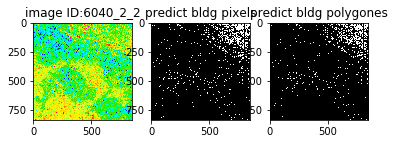

In [69]:
# CHECK
#TRAIN data comparison
check_predict('6040_2_2', model_path) # 6040_2_2 6120_2_2 6120_2_0 6090_2_0 6040_1_3 6040_1_0 6100_1_3 6010_4_2 6140_3_1 6110_1_2 6150_2_3 6160_2_1 6110_3_1 6170_2_4 6170_4_1 6170_0_4 6060_2_3 6010_1_2 6040_4_4 6100_2_2

Self-intersection at or near point 739.51351351351354 315.40540540540542


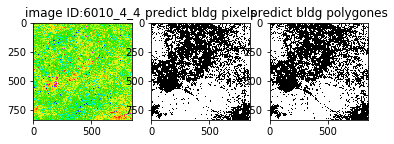

In [46]:
#VAL data comparison
check_predict(val_img_names[0], model_path)

Self-intersection at or near point 724.33333333333337 27.333333333333332


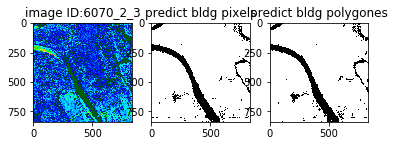

Self-intersection at or near point 803.21739130434787 69.956521739130437


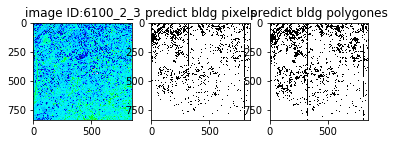

Self-intersection at or near point 453.14285714285717 300.14285714285717


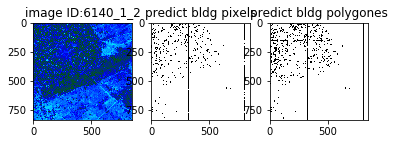

In [47]:
#VAL data comparison
for i in range(1,5):
    check_predict(val_img_names[i], model_path)

Self-intersection at or near point 303 258


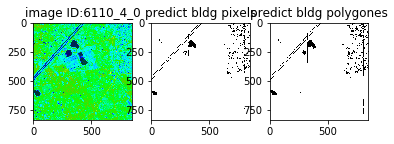

In [48]:
check_predict(val_img_names[4], model_path)

Self-intersection at or near point 793 163.5


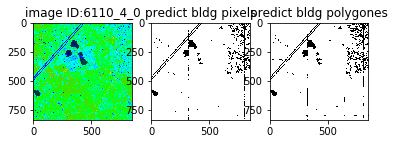

In [70]:
# CHECK TEST
check_predict(val_img_names[4], model_path)